# Main Objective

Lorem ipsum.

# Setup environment

In [1]:
%%capture
!pip install --upgrade tensorflow

In [2]:
%%capture --no-display
import os
import glob
import random
from tensorflow import keras
from keras.metrics import BinaryAccuracy, Precision, Recall
from sklearn.metrics import roc_curve, auc, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from matplotlib import image as img
from tqdm import tqdm

2024-09-05 11:02:23.522011: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-05 11:02:23.534563: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-05 11:02:23.538283: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-05 11:02:23.547300: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-05 11:02:24.201958: W tensorflow/compiler/tf2

In [3]:
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [4]:
# Impose a seed for reproducibility
random_seed = 421
random.seed(random_seed)
np.random.seed(random_seed)

# Dataset

## Dataset description

Lorem ipsum.

## Credits for the dataset

> Krizhevsky, A., & Hinton, G. (2009). Learning multiple layers of features from tiny images.

> Bird, J.J. and Lotfi, A. (2024). CIFAKE: Image Classification and Explainable Identification of AI-Generated Synthetic Images.

## Link to download the dataset

[https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images](https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images)

In [5]:
# Set the local path
path_dataset = '/media/guillaume/DATA/COMPUTER_VISION_DATASETS/CIFAKE'

In [6]:
# Derive the train/test and real/fake paths
path_dataset_train = os.path.join(path_dataset, 'train')
path_dataset_train_real = os.path.join(path_dataset_train, 'REAL')
path_dataset_train_fake = os.path.join(path_dataset_train, 'FAKE')
path_dataset_test = os.path.join(path_dataset, 'test')
path_dataset_test_real = os.path.join(path_dataset_test, 'REAL')
path_dataset_test_fake = os.path.join(path_dataset_test, 'FAKE')

In [7]:
# List the samples
samples_list_train_real = list(glob.glob(os.path.join(path_dataset_train_real, '*.jpg')))
samples_list_test_real = glob.glob(os.path.join(path_dataset_test_real, '*.jpg'))
samples_list_train_fake = glob.glob(os.path.join(path_dataset_train_fake, '*.jpg'))
samples_list_test_fake = glob.glob(os.path.join(path_dataset_test_fake, '*.jpg'))

In [8]:
# Count the number of samples and ensure the distribution is balanced
print('Number of samples:')
print('Train split \t Real images: \t {}'.format(len(samples_list_train_real)))
print('Test split \t Real images: \t {}'.format(len(samples_list_test_real)))
print('Train split \t Fake images: \t {}'.format(len(samples_list_train_fake)))
print('Test split \t Fake images: \t {}'.format(len(samples_list_test_fake)))

Number of samples:
Train split 	 Real images: 	 50000
Test split 	 Real images: 	 10000
Train split 	 Fake images: 	 50000
Test split 	 Fake images: 	 10000


In [9]:
# Apply in-place random shuffling
random.shuffle(samples_list_train_real)
random.shuffle(samples_list_test_real)
random.shuffle(samples_list_train_fake)
random.shuffle(samples_list_test_fake)

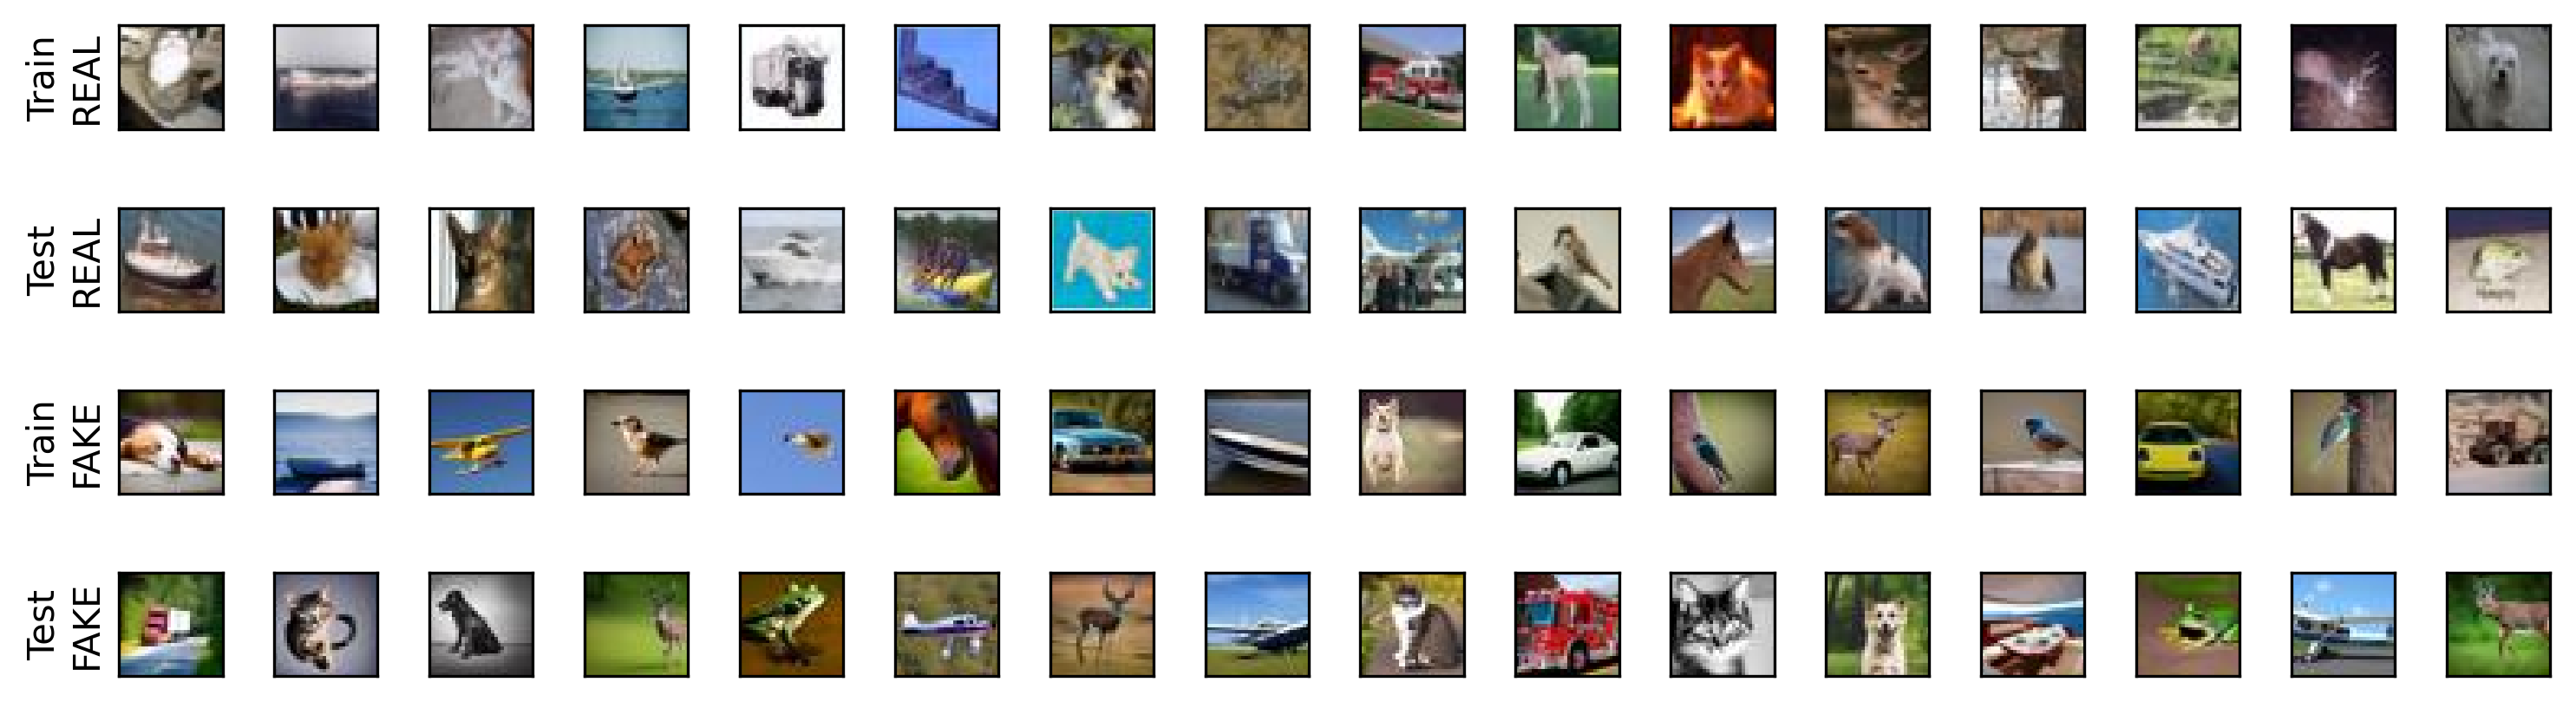

In [10]:
# Display a few images
number_of_displayed_samples = 16

fig, ax = plt.subplots(4, number_of_displayed_samples)
fig.set_dpi(300)
fig.set_size_inches(10, 3, forward=True)

for index in range(number_of_displayed_samples):

    axx = ax[0, index]
    fig.sca(axx)
    plt.imshow(img.imread(os.path.join(path_dataset_train_real, samples_list_train_real[index])))
    plt.ylabel('Train\nREAL') if index==0 else None

    axx = ax[1, index]
    fig.sca(axx)
    plt.imshow(img.imread(os.path.join(path_dataset_test_real, samples_list_test_real[index])))
    plt.ylabel('Test\nREAL') if index==0 else None

    axx = ax[2, index]
    fig.sca(axx)
    plt.imshow(img.imread(os.path.join(path_dataset_train_fake, samples_list_train_fake[index])))
    plt.ylabel('Train\nFAKE') if index==0 else None

    axx = ax[3, index]
    fig.sca(axx)
    plt.imshow(img.imread(os.path.join(path_dataset_test_fake, samples_list_test_fake[index])))
    plt.ylabel('Test\nFAKE') if index==0 else None

[axx.set_xticks([]) for axx in ax.ravel()]
[axx.set_yticks([]) for axx in ax.ravel()]
plt.tight_layout()
plt.show()

# Dataloader

In [11]:
image_height, image_width = 32, 32
batch_size = 64
validation_split = 0.2

# Dataloader for the train split
train_set_dataloader = tf.keras.utils.image_dataset_from_directory(
    path_dataset_train,
    shuffle=True,
    seed=random_seed,
    validation_split=1-validation_split,
    subset='training',    
    batch_size=batch_size,
    image_size=(image_height, image_width))
print('Classes for the train split: {}'.format(train_set_dataloader.class_names))

# Dataloader for the validation split
validation_set_dataloader = tf.keras.utils.image_dataset_from_directory(
    path_dataset_train,
    shuffle=True,
    seed=random_seed,
    validation_split=validation_split,
    subset='validation',    
    batch_size=batch_size,
    image_size=(image_height, image_width))
print('Classes for the validation split: {}'.format(validation_set_dataloader.class_names))

# Dataloader for the test split
test_set_dataloader = tf.keras.utils.image_dataset_from_directory(
    path_dataset_test,
    shuffle=True,
    seed=random_seed,
    batch_size=batch_size,
    image_size=(image_height, image_width))
print('Classes for the test split: {}'.format(test_set_dataloader.class_names))

Found 100000 files belonging to 2 classes.
Using 20000 files for training.


I0000 00:00:1725526951.506765   46784 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725526951.529956   46784 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725526951.530113   46784 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725526951.530902   46784 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Classes for the train split: ['FAKE', 'REAL']
Found 100000 files belonging to 2 classes.
Using 20000 files for validation.
Classes for the validation split: ['FAKE', 'REAL']
Found 20000 files belonging to 2 classes.
Classes for the test split: ['FAKE', 'REAL']


# Helper functions 

In [12]:
def plot_metrics(model_history, test_loss, test_recall, test_accuracy, test_precision, number_of_epochs):
    fig, ax = plt.subplots(2, 2)
    fig.set_dpi(300)
    fig.set_size_inches(12, 12, forward=True)

    metric_name = 'loss'
    axx = ax[0, 0]
    fig.sca(axx)
    plt.plot(model_history.history['{}'.format(metric_name)], label='{}'.format(metric_name))
    plt.plot(model_history.history['val_{}'.format(metric_name)], label='val_{}'.format(metric_name))
    plt.scatter(number_of_epochs -1, test_loss, color='darkgreen', label='test_{}'.format(metric_name))
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()

    metric_name = 'recall'
    axx = ax[0, 1]
    fig.sca(axx)
    plt.plot(model_history.history['{}'.format(metric_name)], label='{}'.format(metric_name))
    plt.plot(model_history.history['val_{}'.format(metric_name)], label='val_{}'.format(metric_name))
    plt.scatter(number_of_epochs -1, test_recall, color='darkgreen', label='test_{}'.format(metric_name))
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()

    metric_name = 'accuracy'
    axx = ax[1, 0]
    fig.sca(axx)
    plt.plot(model_history.history['{}'.format(metric_name)], label='{}'.format(metric_name))
    plt.plot(model_history.history['val_{}'.format(metric_name)], label='val_{}'.format(metric_name))
    plt.scatter(number_of_epochs -1, test_accuracy, color='darkgreen', label='test_{}'.format(metric_name))    
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    
    metric_name = 'precision'
    axx = ax[1, 1]
    fig.sca(axx)
    plt.plot(model_history.history['{}'.format(metric_name)], label='{}'.format(metric_name))
    plt.plot(model_history.history['val_{}'.format(metric_name)], label='val_{}'.format(metric_name))
    plt.scatter(number_of_epochs -1, test_precision, color='darkgreen', label='test_{}'.format(metric_name))    
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [13]:
def evaluate_model(model, dataloader, split_name):
    loss, accuracy, precision, recall = model.evaluate(dataloader)
    print('Dataset: {}'.format(split_name))
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    return loss, accuracy, precision, recall

In [14]:
def get_predictions_and_labels(dataloader, model):
    predicted_values = np.array([])
    predicted_classes = np.array([])
    labels = np.array([])    
    for x, y in dataloader:        
        predicted_values = np.concatenate([predicted_values, model(x)[:,0]])
        predicted_classes = np.concatenate([predicted_classes, [0 if pred < 0.5 else 1 for pred in model(x)]])
        labels = np.concatenate([labels, y])
    return predicted_values, predicted_classes, labels

In [30]:
def plot_confusion_matrix(labels, predicted_classes, class_names):
    cm = confusion_matrix(labels, predicted_classes)
    plt.figure()
    fig.set_dpi(300)
    fig.set_size_inches(12, 12, forward=True)
    sns.heatmap(cm/np.sum(cm), annot=True, cmap='Blues',fmt='.2%', square=True, xticklabels=class_names, yticklabels=class_names, vmin=0, vmax=1)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

In [16]:
def plot_roc_curve(labels, predicted_values):
    fpr, tpr, thresholds = roc_curve(labels, predicted_values)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    fig.set_dpi(300)
    fig.set_size_inches(12, 12, forward=True)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='ROC AUC = {:.3f})'.format(roc_auc))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.tight_layout()    
    plt.gca().set_aspect('equal')
    plt.show()

In [17]:
def plot_predicted_values_per_class(predicted_values, labels):
    plt.figure()
    fig.set_dpi(300)
    fig.set_size_inches(12, 12, forward=True)
    plt.plot(np.sort(predicted_values[labels==1]), label='Real images')
    plt.plot(np.flip(np.sort(predicted_values[labels==0])), label='Fake images')
    plt.xlabel('Samples (sorted)')
    plt.ylabel('Predicted values')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [18]:
def plot_extreme_predictions(predicted_values, labels):

    indices_of_real_images = np.where(labels==1)
    indices_of_fake_images = np.where(labels==0)

    predicted_value_for_real_images = predicted_values[labels==1]
    predicted_value_for_fake_images = predicted_values[labels==0]

    indices_of_real_images_sorted_from_worst_to_best_prediction = np.argsort(predicted_value_for_real_images)
    indices_of_fake_images_sorted_from_worst_to_best_prediction = np.flip(np.argsort(predicted_value_for_fake_images))
    
    # Display a few images
    number_of_displayed_samples = 16
    
    fig, ax = plt.subplots(4, number_of_displayed_samples)
    fig.set_dpi(300)
    fig.set_size_inches(10, 3, forward=True)
    
    for i in range(number_of_displayed_samples):
    
        axx = ax[0, i]
        fig.sca(axx)
        index = indices_of_real_images_sorted_from_worst_to_best_prediction[i]
        plt.imshow(img.imread(os.path.join(path_dataset_train_real, samples_list_train_real[index])))
        plt.ylabel('REAL\n(failures)') if i==0 else None
    
        axx = ax[1, i]
        fig.sca(axx)
        index = indices_of_real_images_sorted_from_worst_to_best_prediction[9999-i]        
        plt.imshow(img.imread(os.path.join(path_dataset_test_real, samples_list_test_real[index])))
        plt.ylabel('REAL\n(success)') if i==0 else None
    
        axx = ax[2, i]
        fig.sca(axx)
        index = indices_of_fake_images_sorted_from_worst_to_best_prediction[i]        
        plt.imshow(img.imread(os.path.join(path_dataset_train_fake, samples_list_train_fake[index])))
        plt.ylabel('FAKE\n(failures)') if i==0 else None
    
        axx = ax[3, i]
        fig.sca(axx)
        index = indices_of_fake_images_sorted_from_worst_to_best_prediction[9999-i]             
        plt.imshow(img.imread(os.path.join(path_dataset_test_fake, samples_list_test_fake[index])))
        plt.ylabel('FAKE\n(success)') if i==0 else None    
    
    [axx.set_xticks([]) for axx in ax.ravel()]
    [axx.set_yticks([]) for axx in ax.ravel()]
    plt.tight_layout()    
    plt.suptitle('Correctly (\'success\') and incorrectly (\'failures\') classified images')
    plt.show()

# Model 0 | Random predictions | ROC AUC 0.492

In [37]:
# Generate random predictions
labels = np.array([])
for x, y in test_set_dataloader:
    labels = np.concatenate([labels, y])
    
predicted_values = np.random.rand(len(labels),)
predicted_values -= np.min(predicted_values)
predicted_values /= np.max(predicted_values)
predicted_classes = (predicted_values > 0.5).astype(np.int32)

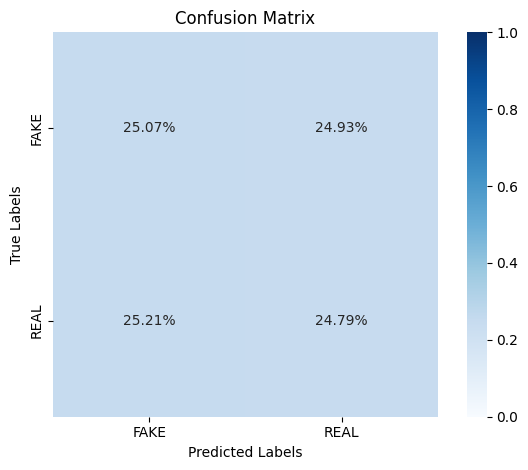

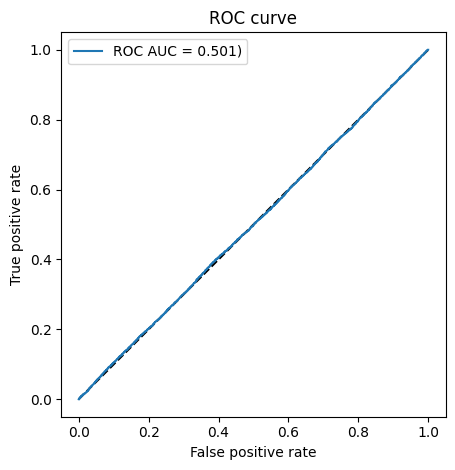

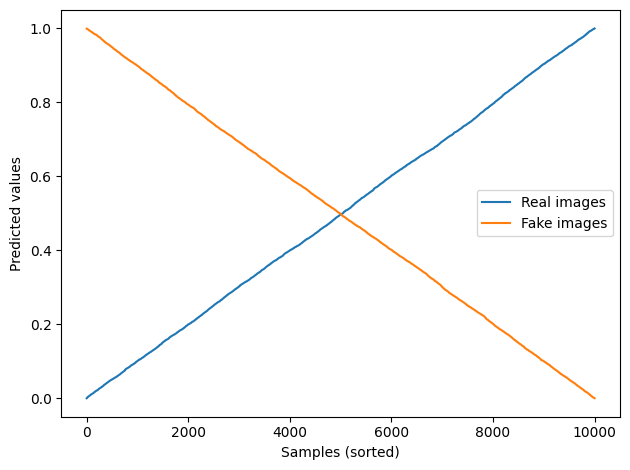

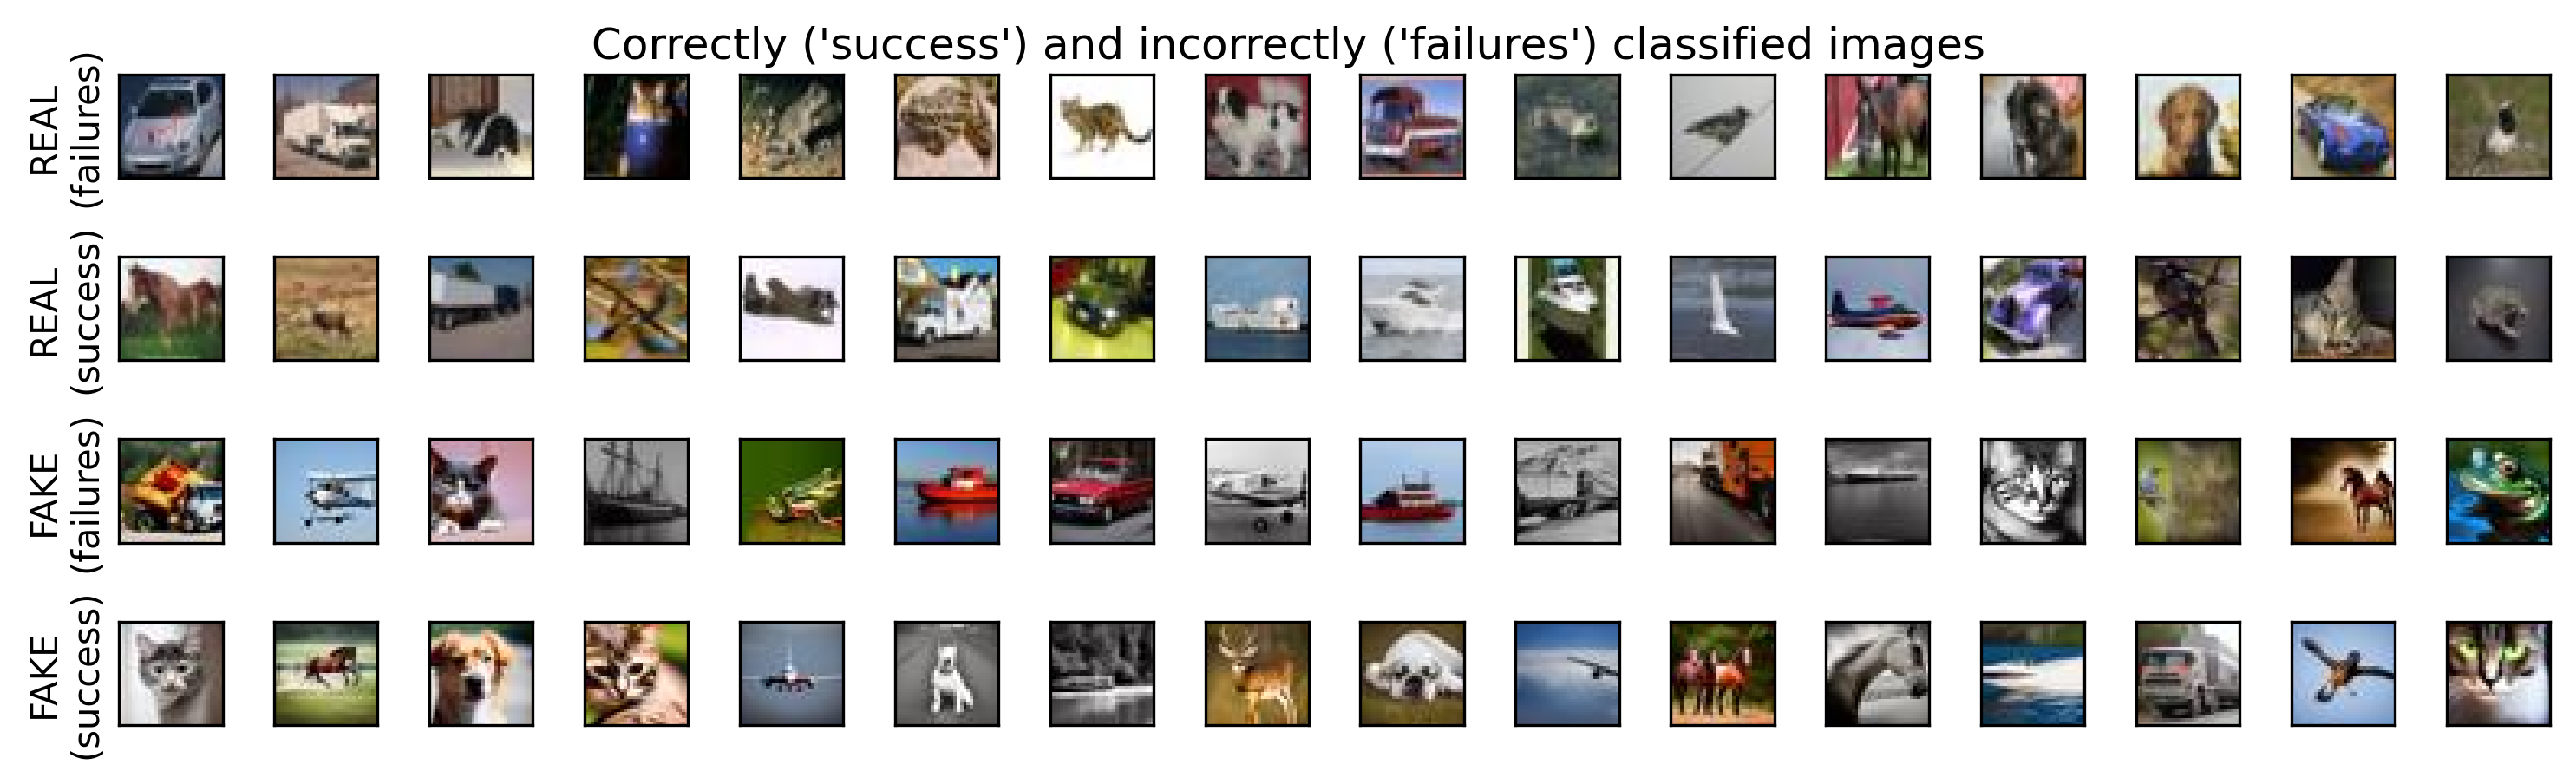

In [38]:
# Plot results
plot_roc_curve(labels, predicted_values)
plot_confusion_matrix(labels, predicted_classes, test_set_dataloader.class_names)
plot_predicted_values_per_class(predicted_values, labels)
plot_extreme_predictions(predicted_values, labels)

# Model 1 | Fully-convolutional, small | 2.3k parameters | ROC AUC 0.952

In [58]:
# Design the model
model = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode='horizontal', seed=random_seed),
    tf.keras.layers.Resizing(image_height, image_width),
    tf.keras.layers.Rescaling(scale=1./127.5, offset=-1),    
    tf.keras.layers.Conv2D(filters=8, kernel_size=3, strides=(1, 1), padding='same', activation='silu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')])

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall')])

# Build the model and show the summary
model.build(input_shape=(None, image_height, image_width, 3))
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_10 (RandomFlip)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_10 (Resizing)          │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_10 (Rescaling)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_72 (Conv2D)              │ (None, 32, 32, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_78          │ (None, 32, 32, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,305 (9.00 KB)

 Trainable params: 2,289 (8.94 KB)

 Non-trainable params: 16 (64.00 B)

In [ ]:
# Train the model
number_of_epochs = 50
history = model.fit(
    train_set_dataloader, validation_data=validation_set_dataloader, epochs=number_of_epochs, verbose=2)

Epoch 1/50
313/313 - 4s - 14ms/step - accuracy: 0.7346 - loss: 0.5246 - precision: 0.7466 - recall: 0.7078 - val_accuracy: 0.5774 - val_loss: 0.7700 - val_precision: 0.5418 - val_recall: 0.9782
Epoch 2/50
313/313 - 1s - 2ms/step - accuracy: 0.8019 - loss: 0.4321 - precision: 0.7961 - recall: 0.8100 - val_accuracy: 0.7602 - val_loss: 0.5042 - val_precision: 0.6927 - val_recall: 0.9313
Epoch 3/50
313/313 - 1s - 2ms/step - accuracy: 0.8189 - loss: 0.4059 - precision: 0.8122 - recall: 0.8283 - val_accuracy: 0.7954 - val_loss: 0.4521 - val_precision: 0.7421 - val_recall: 0.9028
Epoch 4/50
313/313 - 1s - 3ms/step - accuracy: 0.8273 - loss: 0.3894 - precision: 0.8188 - recall: 0.8392 - val_accuracy: 0.7950 - val_loss: 0.4566 - val_precision: 0.7354 - val_recall: 0.9185
Epoch 5/50
313/313 - 1s - 2ms/step - accuracy: 0.8378 - loss: 0.3703 - precision: 0.8275 - recall: 0.8522 - val_accuracy: 0.7964 - val_loss: 0.4492 - val_precision: 0.7315 - val_recall: 0.9337
Epoch 6/50
313/313 - 1s - 2ms/step

In [23]:
# Infer the model
evaluate_model(model, validation_set_dataloader, 'Validation')
test_loss, test_accuracy, test_precision, test_recall = evaluate_model(model, test_set_dataloader, 'Test')
predicted_values, predicted_classes, labels = get_predictions_and_labels(test_set_dataloader, model)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8800 - loss: 0.2973 - precision: 0.8885 - recall: 0.8636
Dataset: Validation
Loss: 0.3019
Accuracy: 0.8815
Precision: 0.8940
Recall: 0.8645
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8859 - loss: 0.2877 - precision: 0.8976 - recall: 0.8693
Dataset: Test
Loss: 0.2960
Accuracy: 0.8837
Precision: 0.8965
Recall: 0.8674


W0000 00:00:1725527035.228152   46784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725527035.254540   46784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725527035.255216   46784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725527035.255884   46784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725527035.256557   46784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725527035.257229   46784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725527035.260788   46784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725527035.261488   46784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725527035.262192   46784 gp

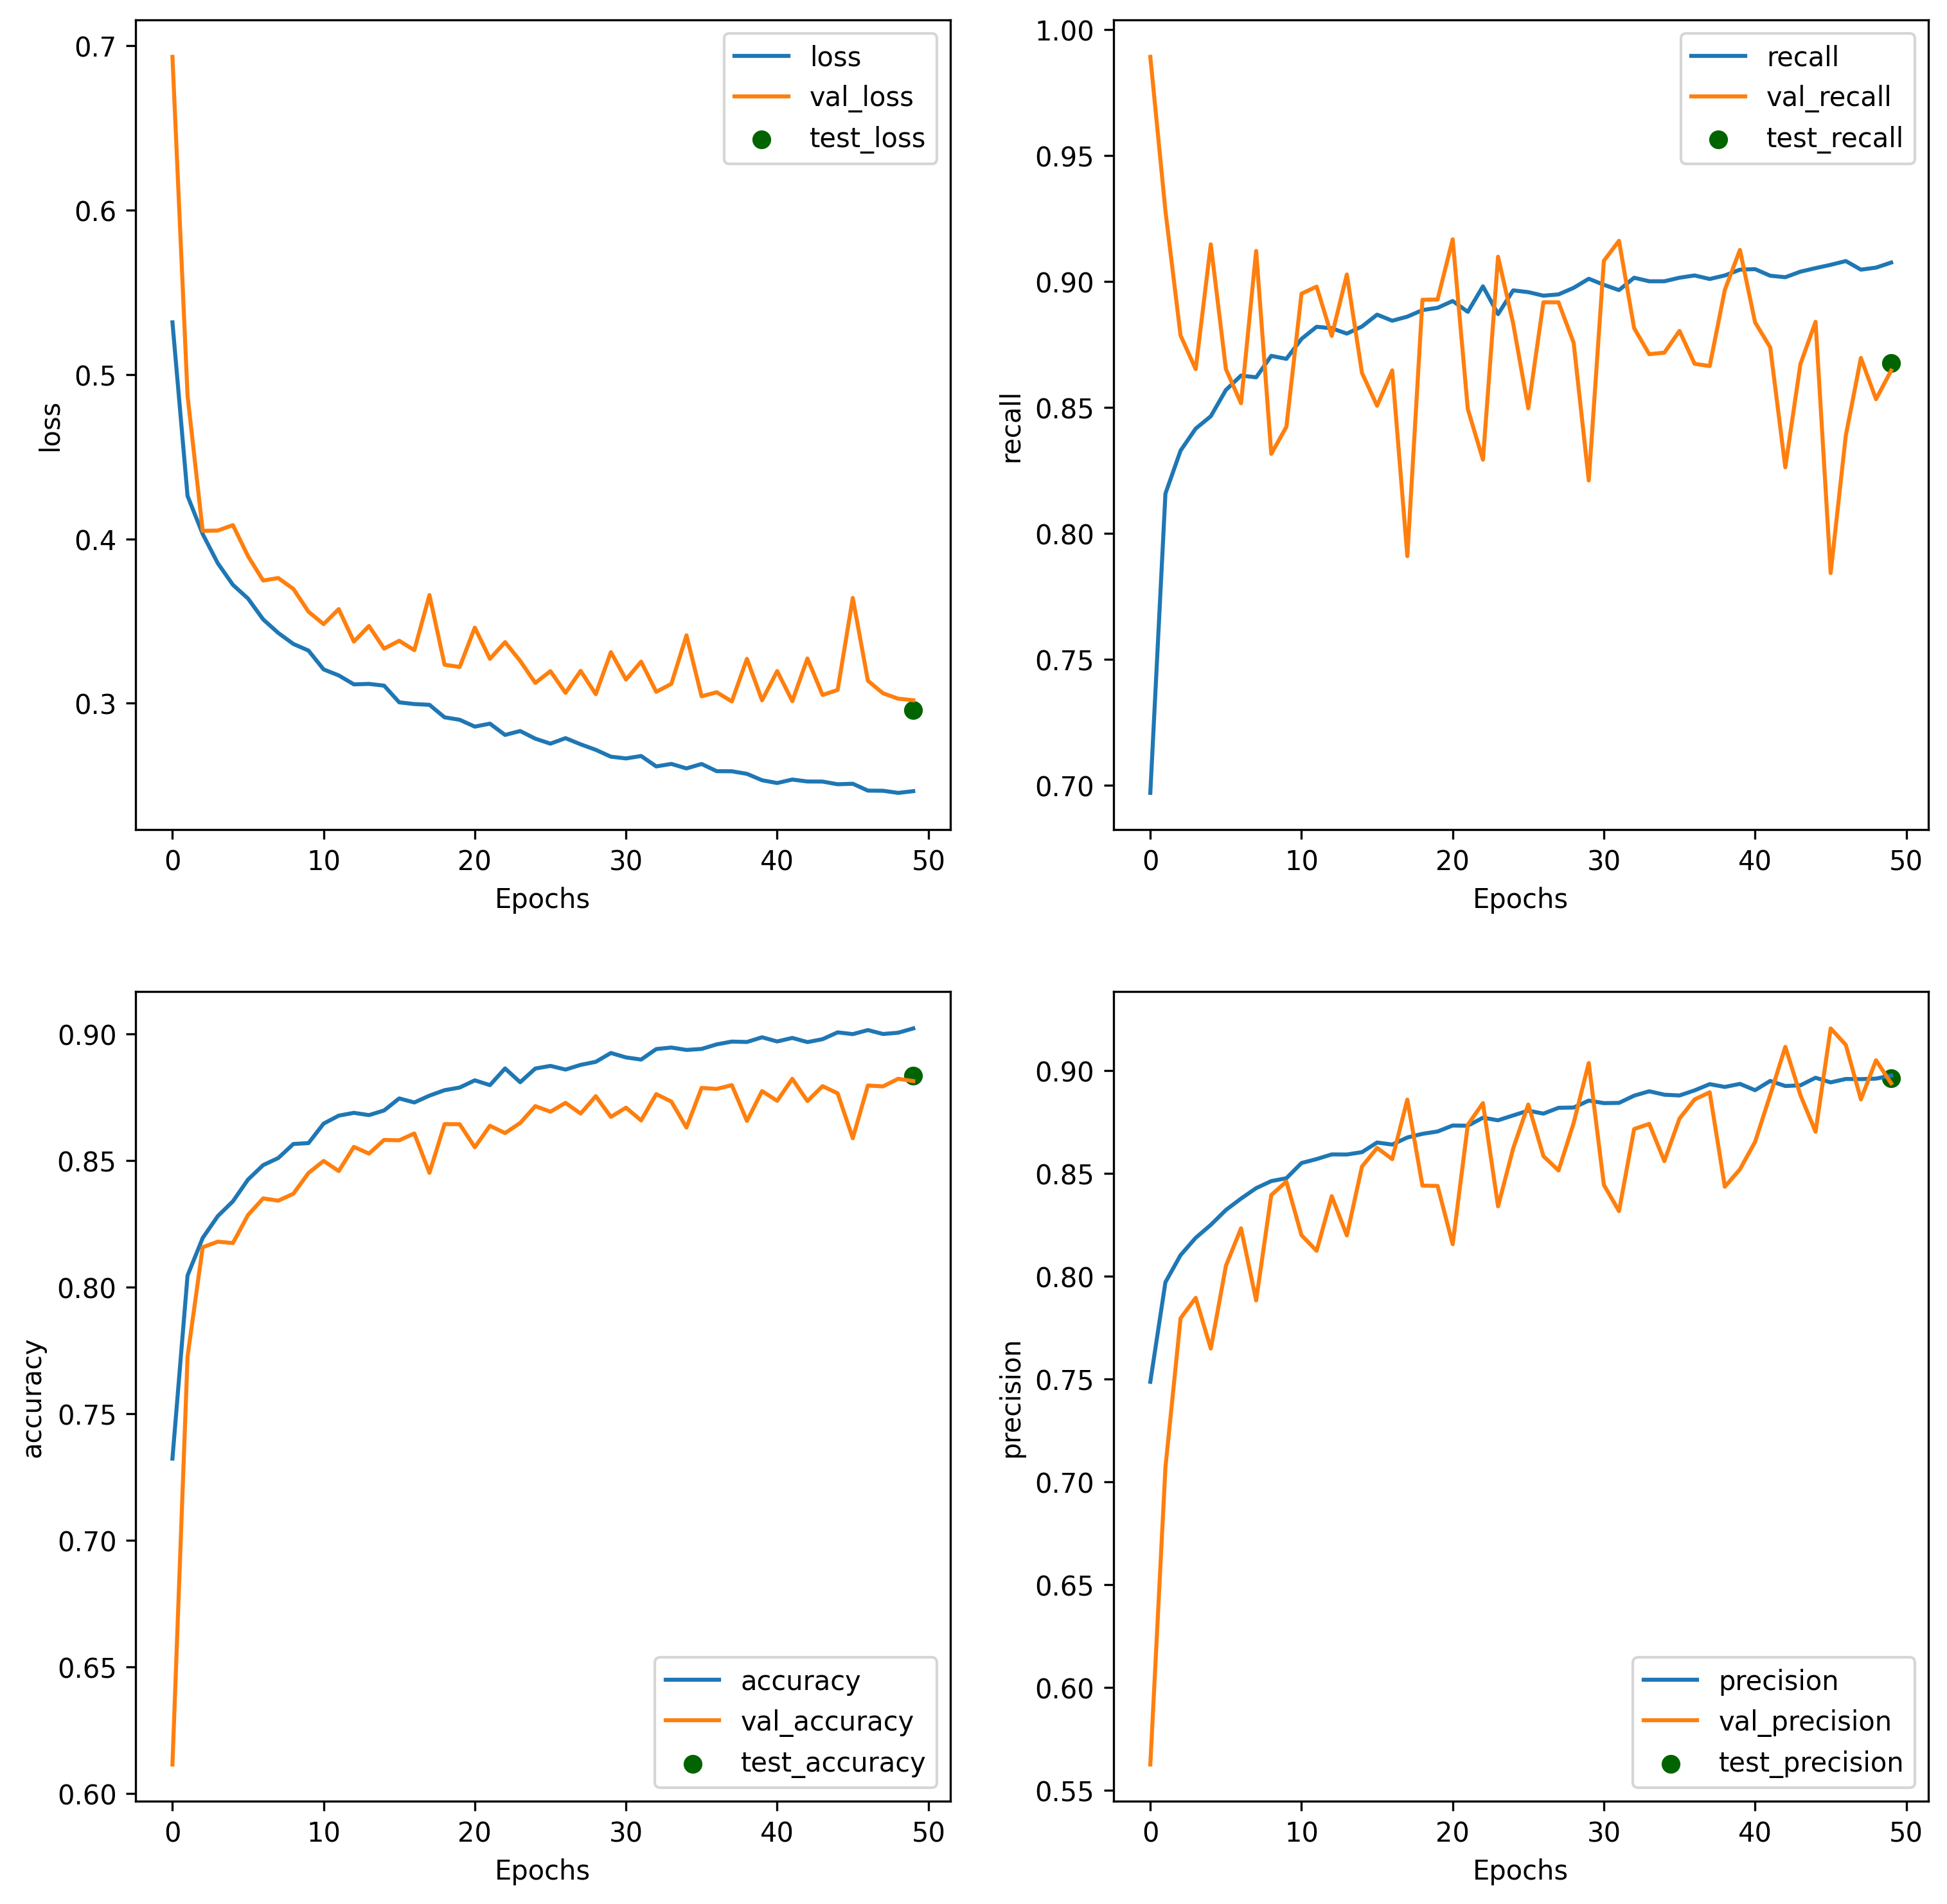

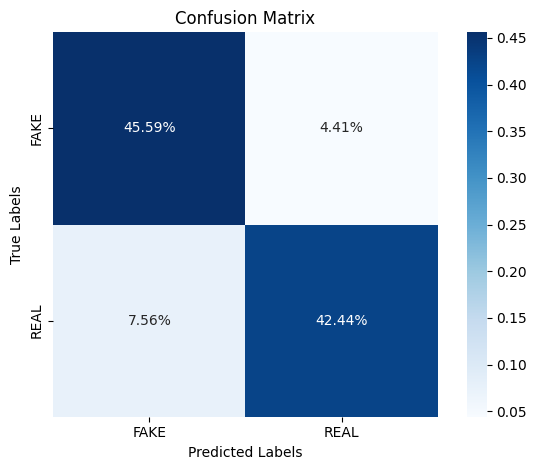

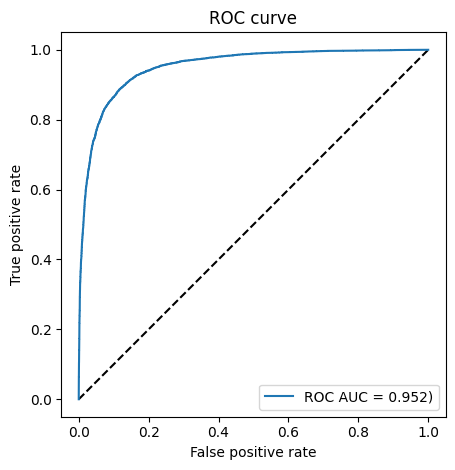

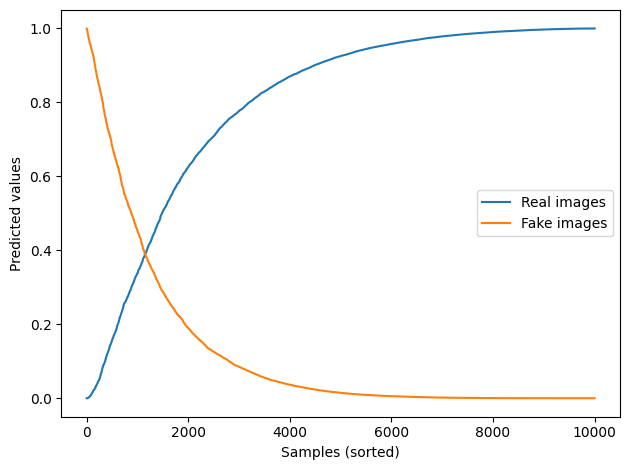

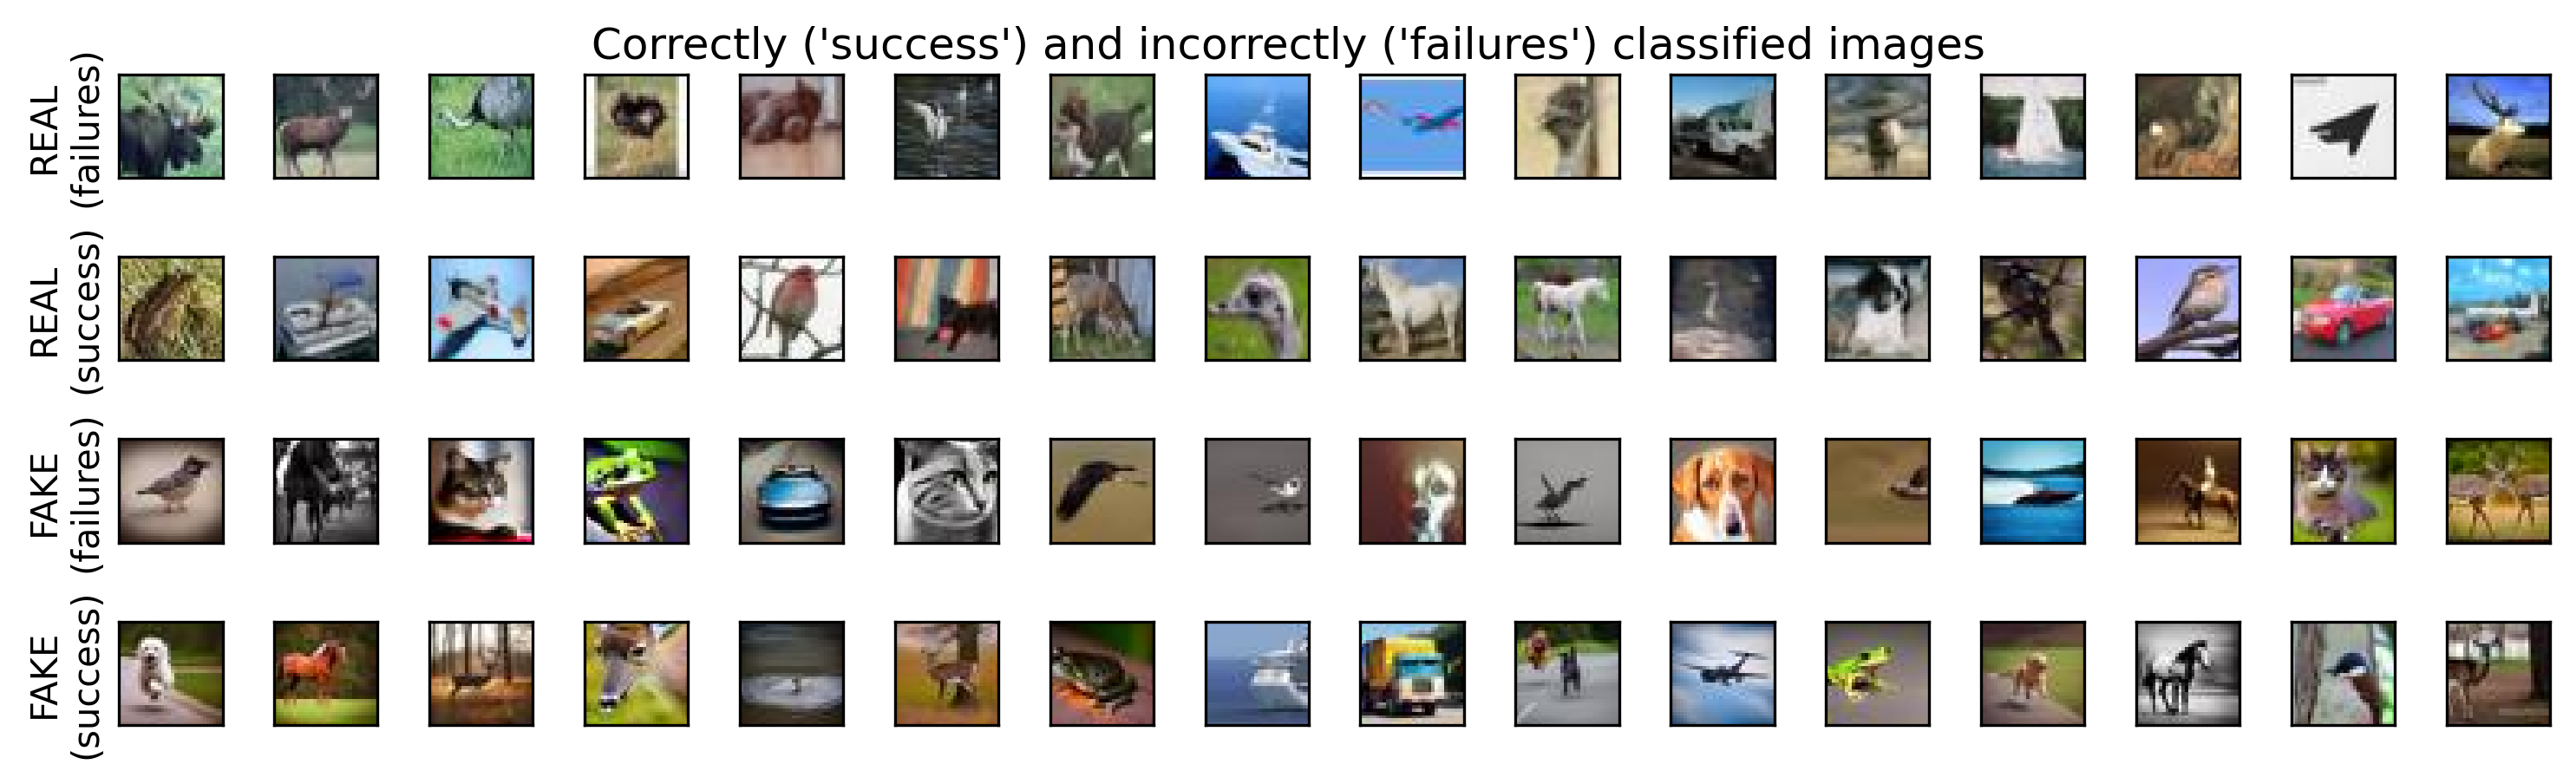

In [24]:
# Plot results
plot_metrics(history, test_loss, test_recall, test_accuracy, test_precision, number_of_epochs)
plot_roc_curve(labels, predicted_values)
plot_confusion_matrix(labels, predicted_classes, test_set_dataloader.class_names)
plot_predicted_values_per_class(predicted_values, labels)
plot_extreme_predictions(predicted_values, labels)

# Model 2 | Fully-convolutional, medium | 1.2M parameters | ROC AUC xxx

In [39]:
# Design the model
model = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode='horizontal', seed=random_seed),
    tf.keras.layers.Resizing(image_height, image_width),
    tf.keras.layers.Rescaling(scale=1./127.5, offset=-1),    
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='same', activation='silu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='same', activation='silu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='same', activation='silu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='same', activation='silu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='same', activation='silu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='same', activation='silu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.MaxPooling2D(),    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')])

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall')])

# Build the model and show the summary
model.build(input_shape=(None, image_height, image_width, 3))
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_7 (RandomFlip)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_7 (Resizing)           │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_7 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 1,153,089 (4.40 MB)

 Trainable params: 1,151,297 (4.39 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [40]:
# Train the model
number_of_epochs = 50
history = model.fit(
    train_set_dataloader, validation_data=validation_set_dataloader, epochs=number_of_epochs, verbose=2)

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - accuracy: 0.7112 - loss: 0.7227 - precision: 0.7034 - recall: 0.7219 - val_accuracy: 0.5214 - val_loss: 0.7598 - val_precision: 0.5203 - val_recall: 0.4933
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8678 - loss: 0.3285 - precision: 0.8594 - recall: 0.8773 - val_accuracy: 0.5943 - val_loss: 1.2918 - val_precision: 0.5515 - val_recall: 0.9923
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8912 - loss: 0.2792 - precision: 0.8862 - recall: 0.8960 - val_accuracy: 0.7566 - val_loss: 0.5643 - val_precision: 0.6789 - val_recall: 0.9697
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8999 - loss: 0.2567 - precision: 0.8988 - recall: 0.8995 - val_accuracy: 0.7624 - val_loss: 0.6118 - val_precision: 0.6806 - val_recall: 0.9847
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9042 - loss: 0.2461 - precision: 0.9033 - recall: 0.9038 - val_accuracy: 0.8576 - val_lo

In [41]:
# Infer the model
evaluate_model(model, validation_set_dataloader, 'Validation')
test_loss, test_accuracy, test_precision, test_recall = evaluate_model(model, test_set_dataloader, 'Test')
predicted_values, predicted_classes, labels = get_predictions_and_labels(test_set_dataloader, model)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9349 - loss: 0.1833 - precision: 0.8953 - recall: 0.9826
Dataset: Validation
Loss: 0.1860
Accuracy: 0.9356
Precision: 0.8998
Recall: 0.9798
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9413 - loss: 0.1772 - precision: 0.9089 - recall: 0.9801
Dataset: Test
Loss: 0.1855
Accuracy: 0.9377
Precision: 0.9053
Recall: 0.9777


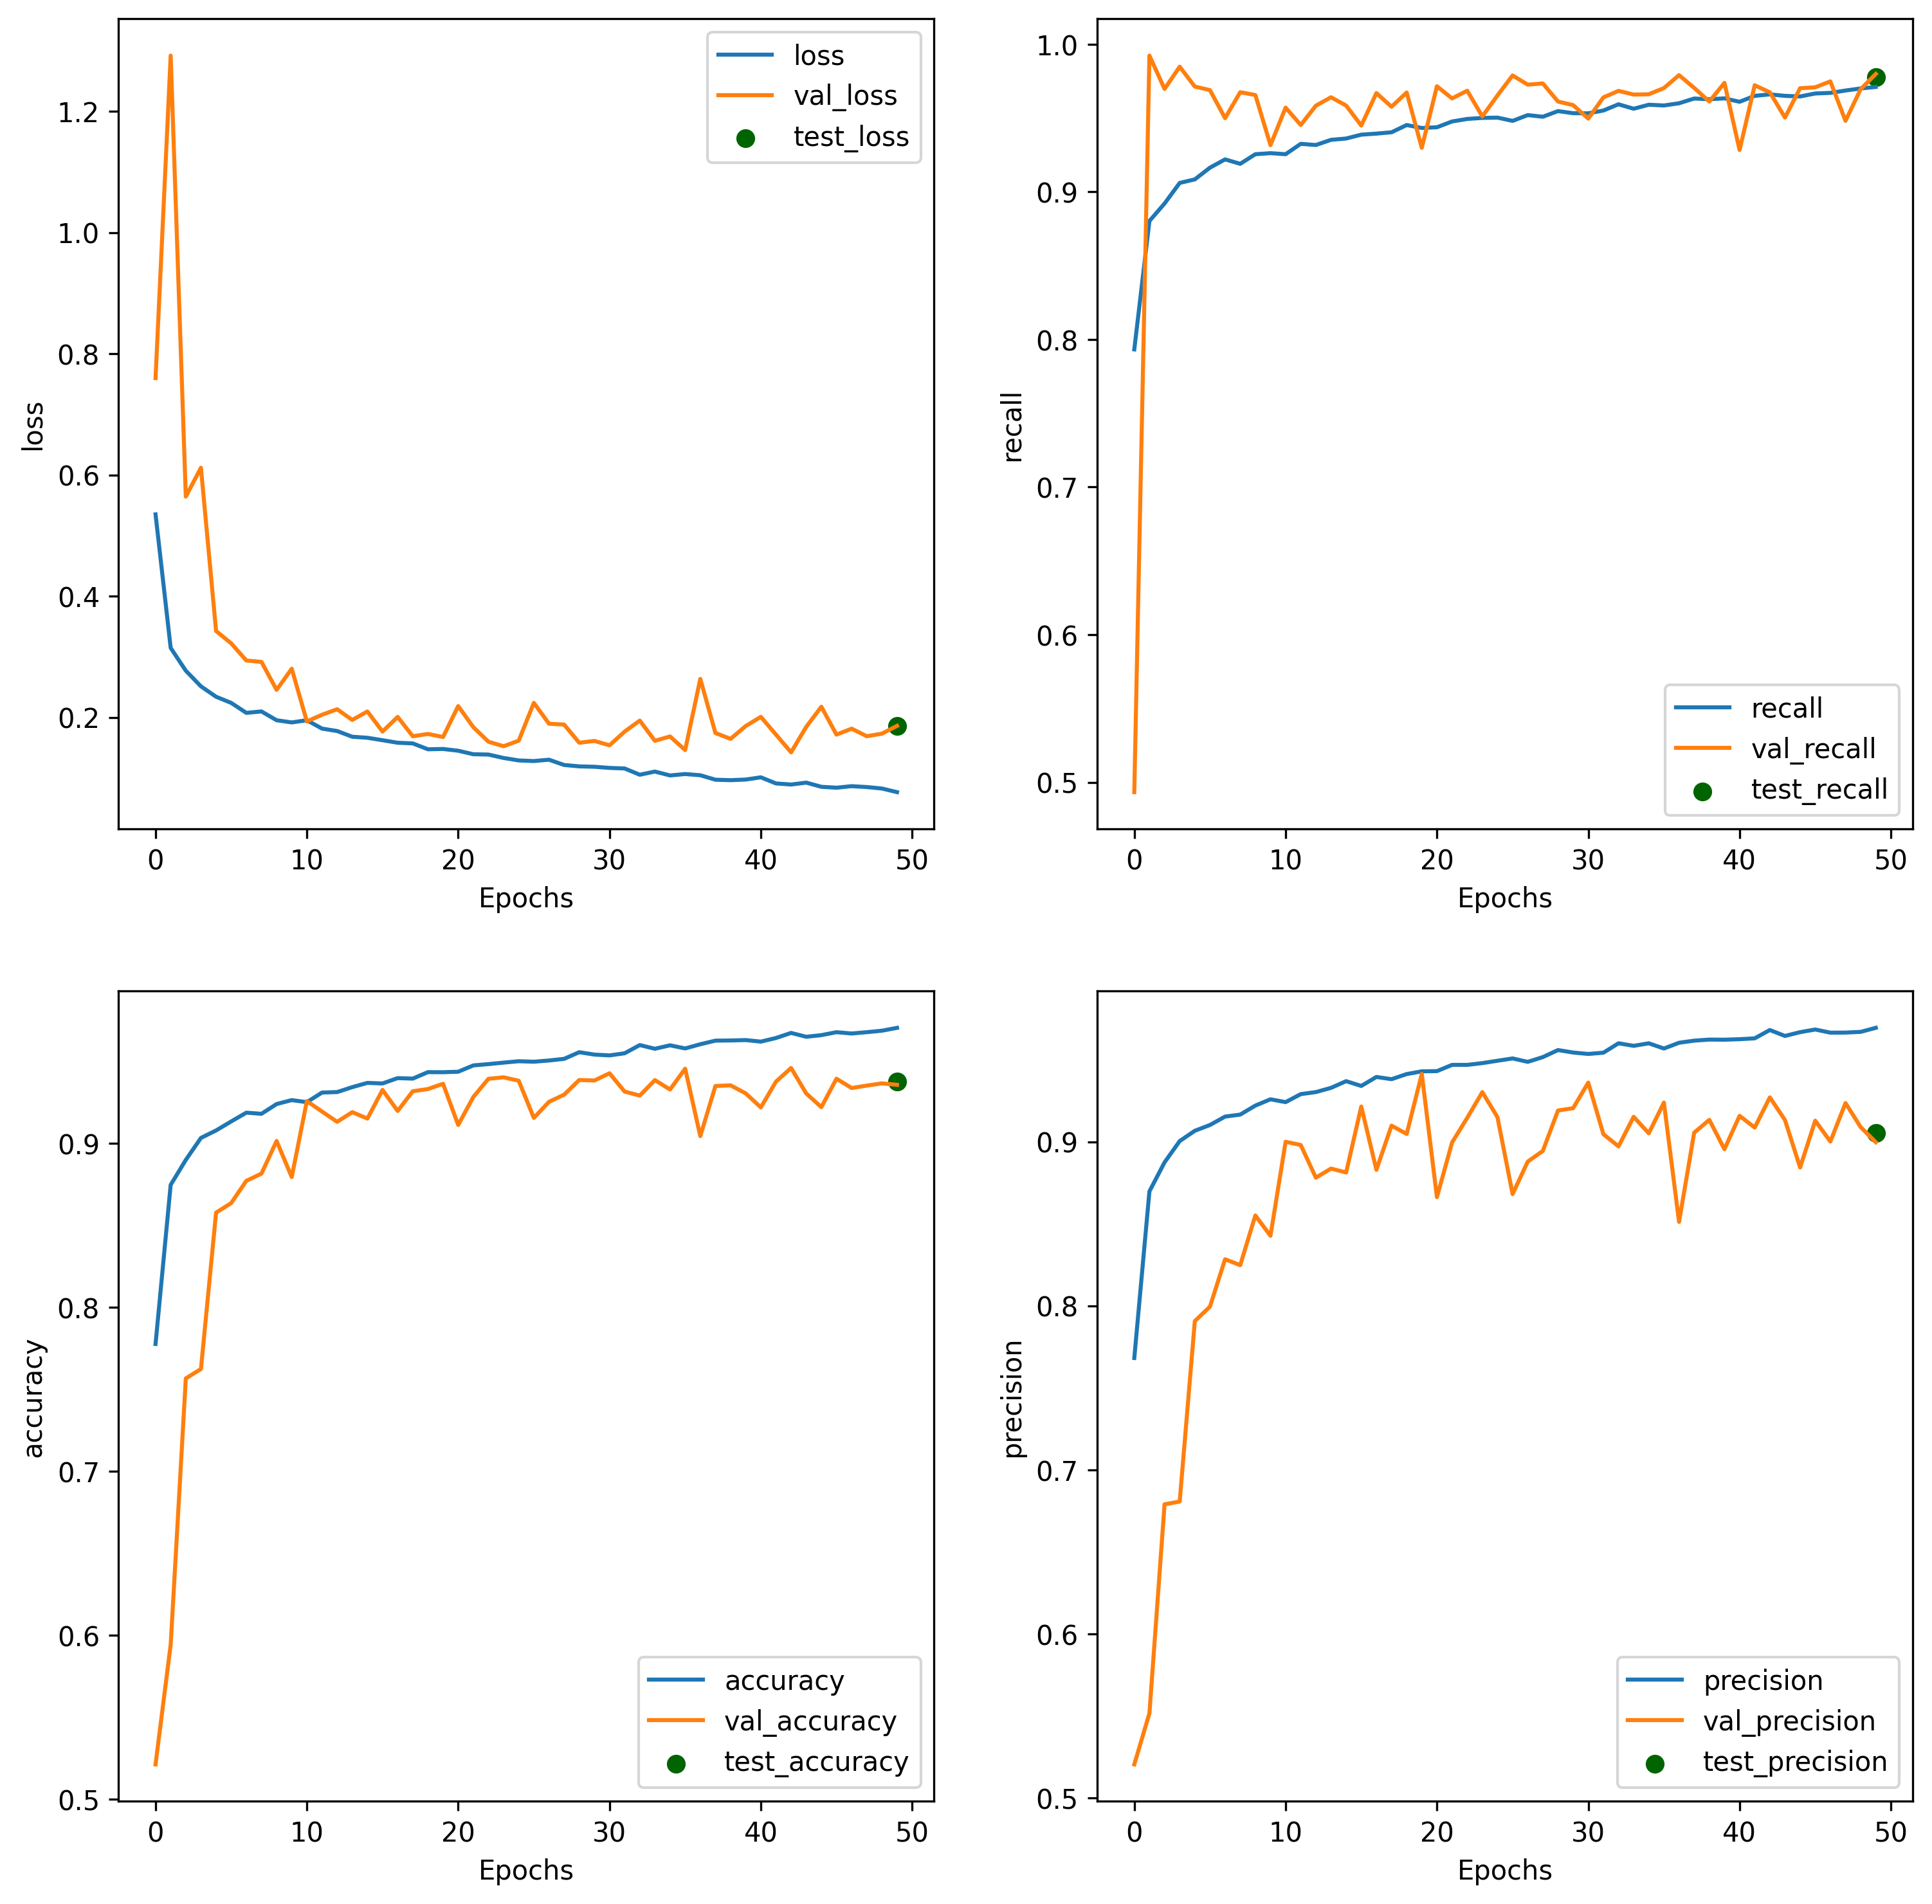

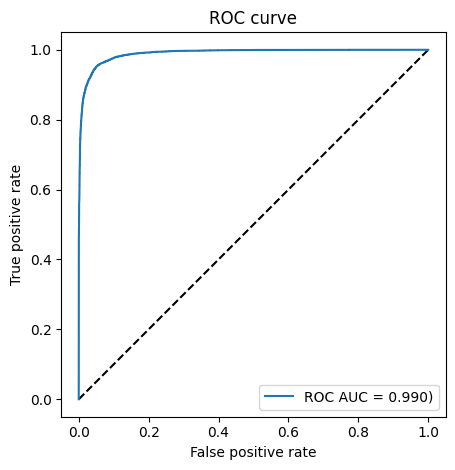

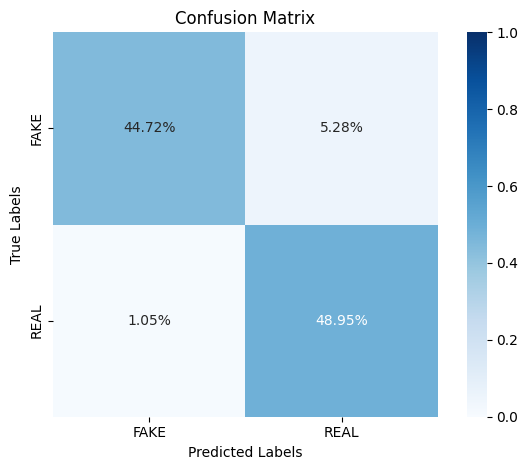

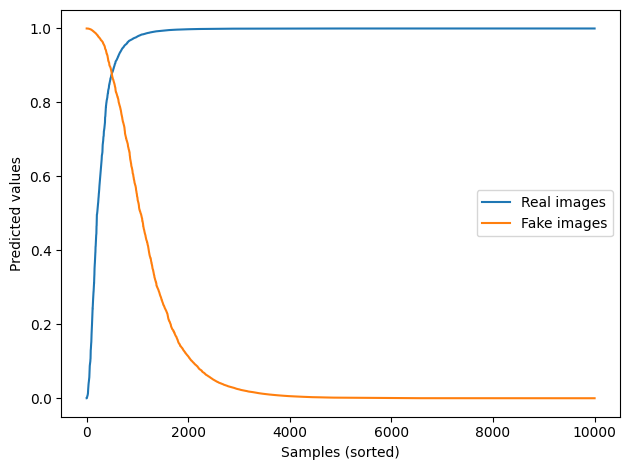

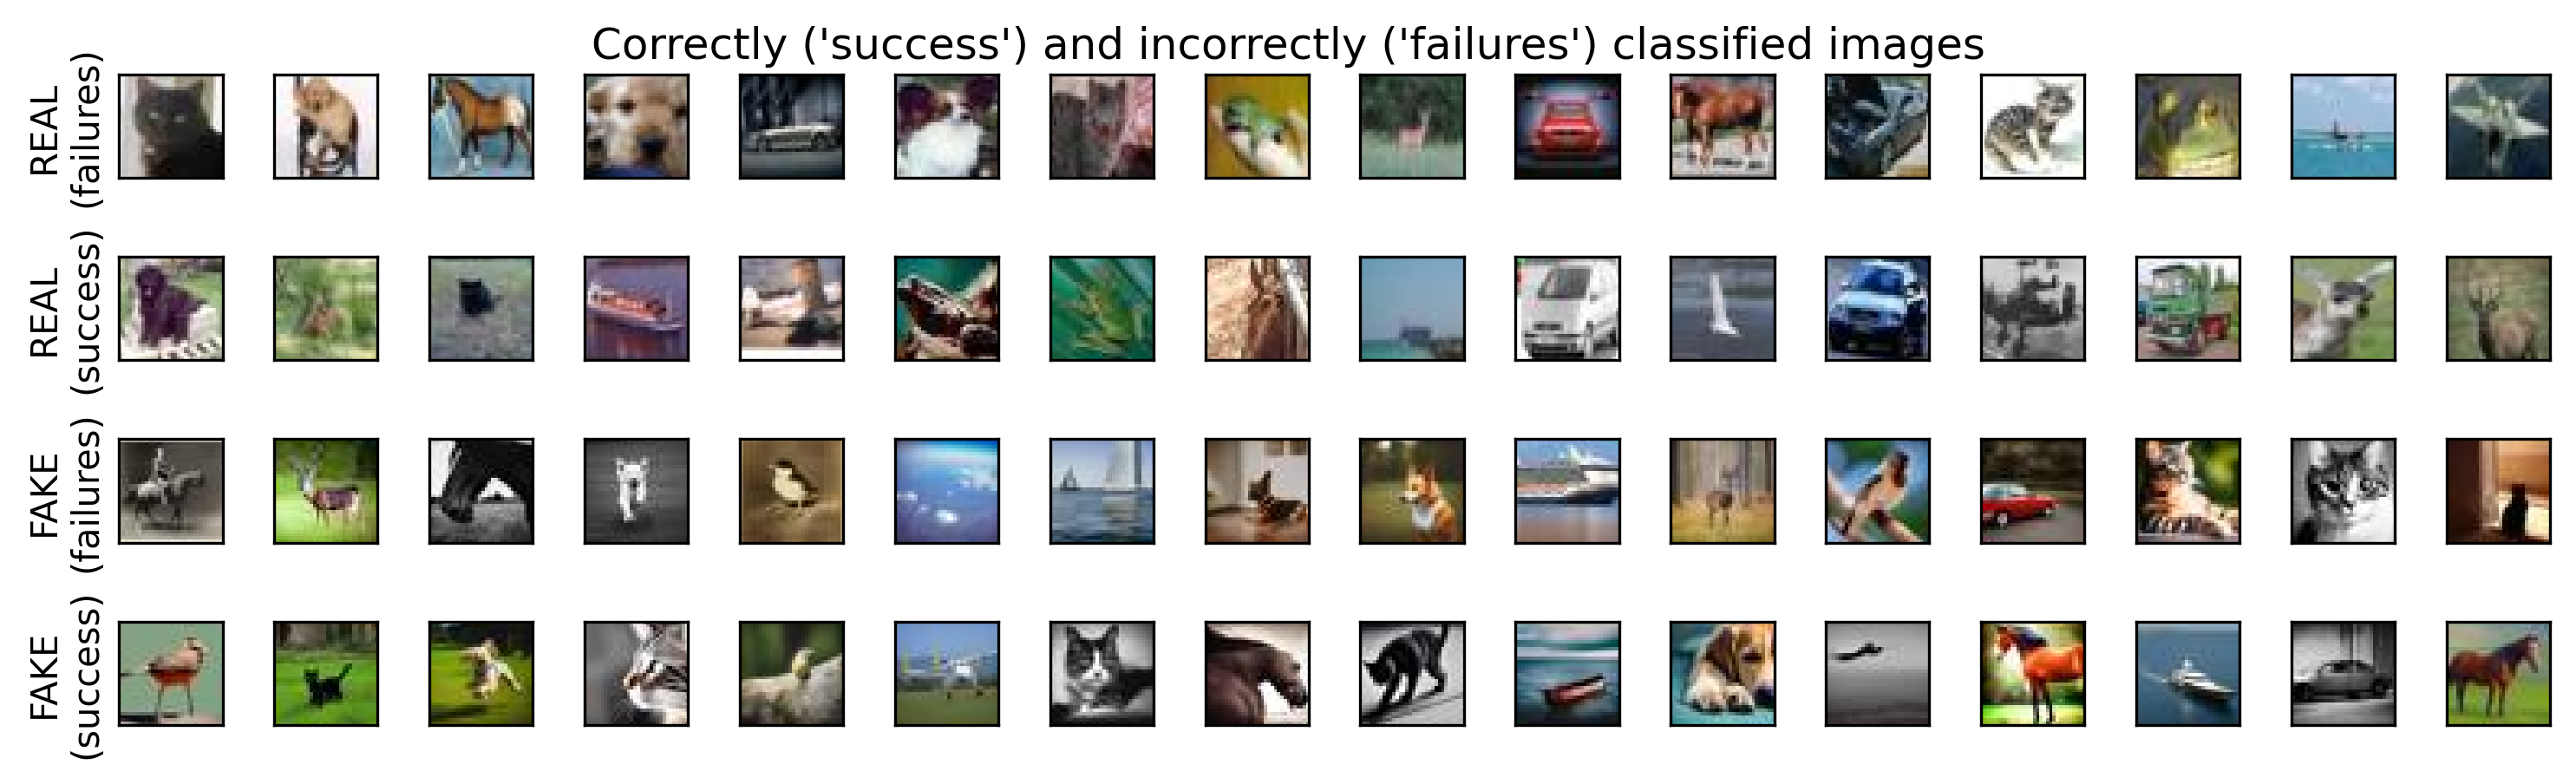

In [42]:
# Plot results
plot_metrics(history, test_loss, test_recall, test_accuracy, test_precision, number_of_epochs)
plot_roc_curve(labels, predicted_values)
plot_confusion_matrix(labels, predicted_classes, test_set_dataloader.class_names)
plot_predicted_values_per_class(predicted_values, labels)
plot_extreme_predictions(predicted_values, labels)

# Model 3 | Mostly dense connections | 2.1M parameters | ROC AUC XXX

In [47]:
# Design the model
model = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode='horizontal', seed=random_seed),
    tf.keras.layers.Resizing(image_height, image_width),
    tf.keras.layers.Rescaling(scale=1./127.5, offset=-1),    
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='same', activation='silu'),    
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.MaxPooling2D(),    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')])

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall')])

# Build the model and show the summary
model.build(input_shape=(None, image_height, image_width, 3))
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_9 (RandomFlip)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_9 (Resizing)           │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_9 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,099,457 (8.01 MB)

 Trainable params: 2,099,329 (8.01 MB)

 Non-trainable params: 128 (512.00 B)

In [48]:
# Train the model
number_of_epochs = 50
history = model.fit(
    train_set_dataloader, validation_data=validation_set_dataloader, epochs=number_of_epochs, verbose=2)

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6900 - loss: 0.6019 - precision: 0.6890 - recall: 0.6805 - val_accuracy: 0.6612 - val_loss: 0.6850 - val_precision: 0.5976 - val_recall: 0.9782
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8062 - loss: 0.4300 - precision: 0.8059 - recall: 0.8031 - val_accuracy: 0.8148 - val_loss: 0.4134 - val_precision: 0.7747 - val_recall: 0.8856
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8268 - loss: 0.3957 - precision: 0.8260 - recall: 0.8254 - val_accuracy: 0.7740 - val_loss: 0.4974 - val_precision: 0.6996 - val_recall: 0.9569
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8320 - loss: 0.3841 - precision: 0.8295 - recall: 0.8328 - val_accuracy: 0.8406 - val_loss: 0.3681 - val_precision: 0.8108 - val_recall: 0.8866
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8443 - loss: 0.3627 - precision: 0.8419 - recall: 0.8453 - val_accuracy: 0.8212 - val_loss: 0

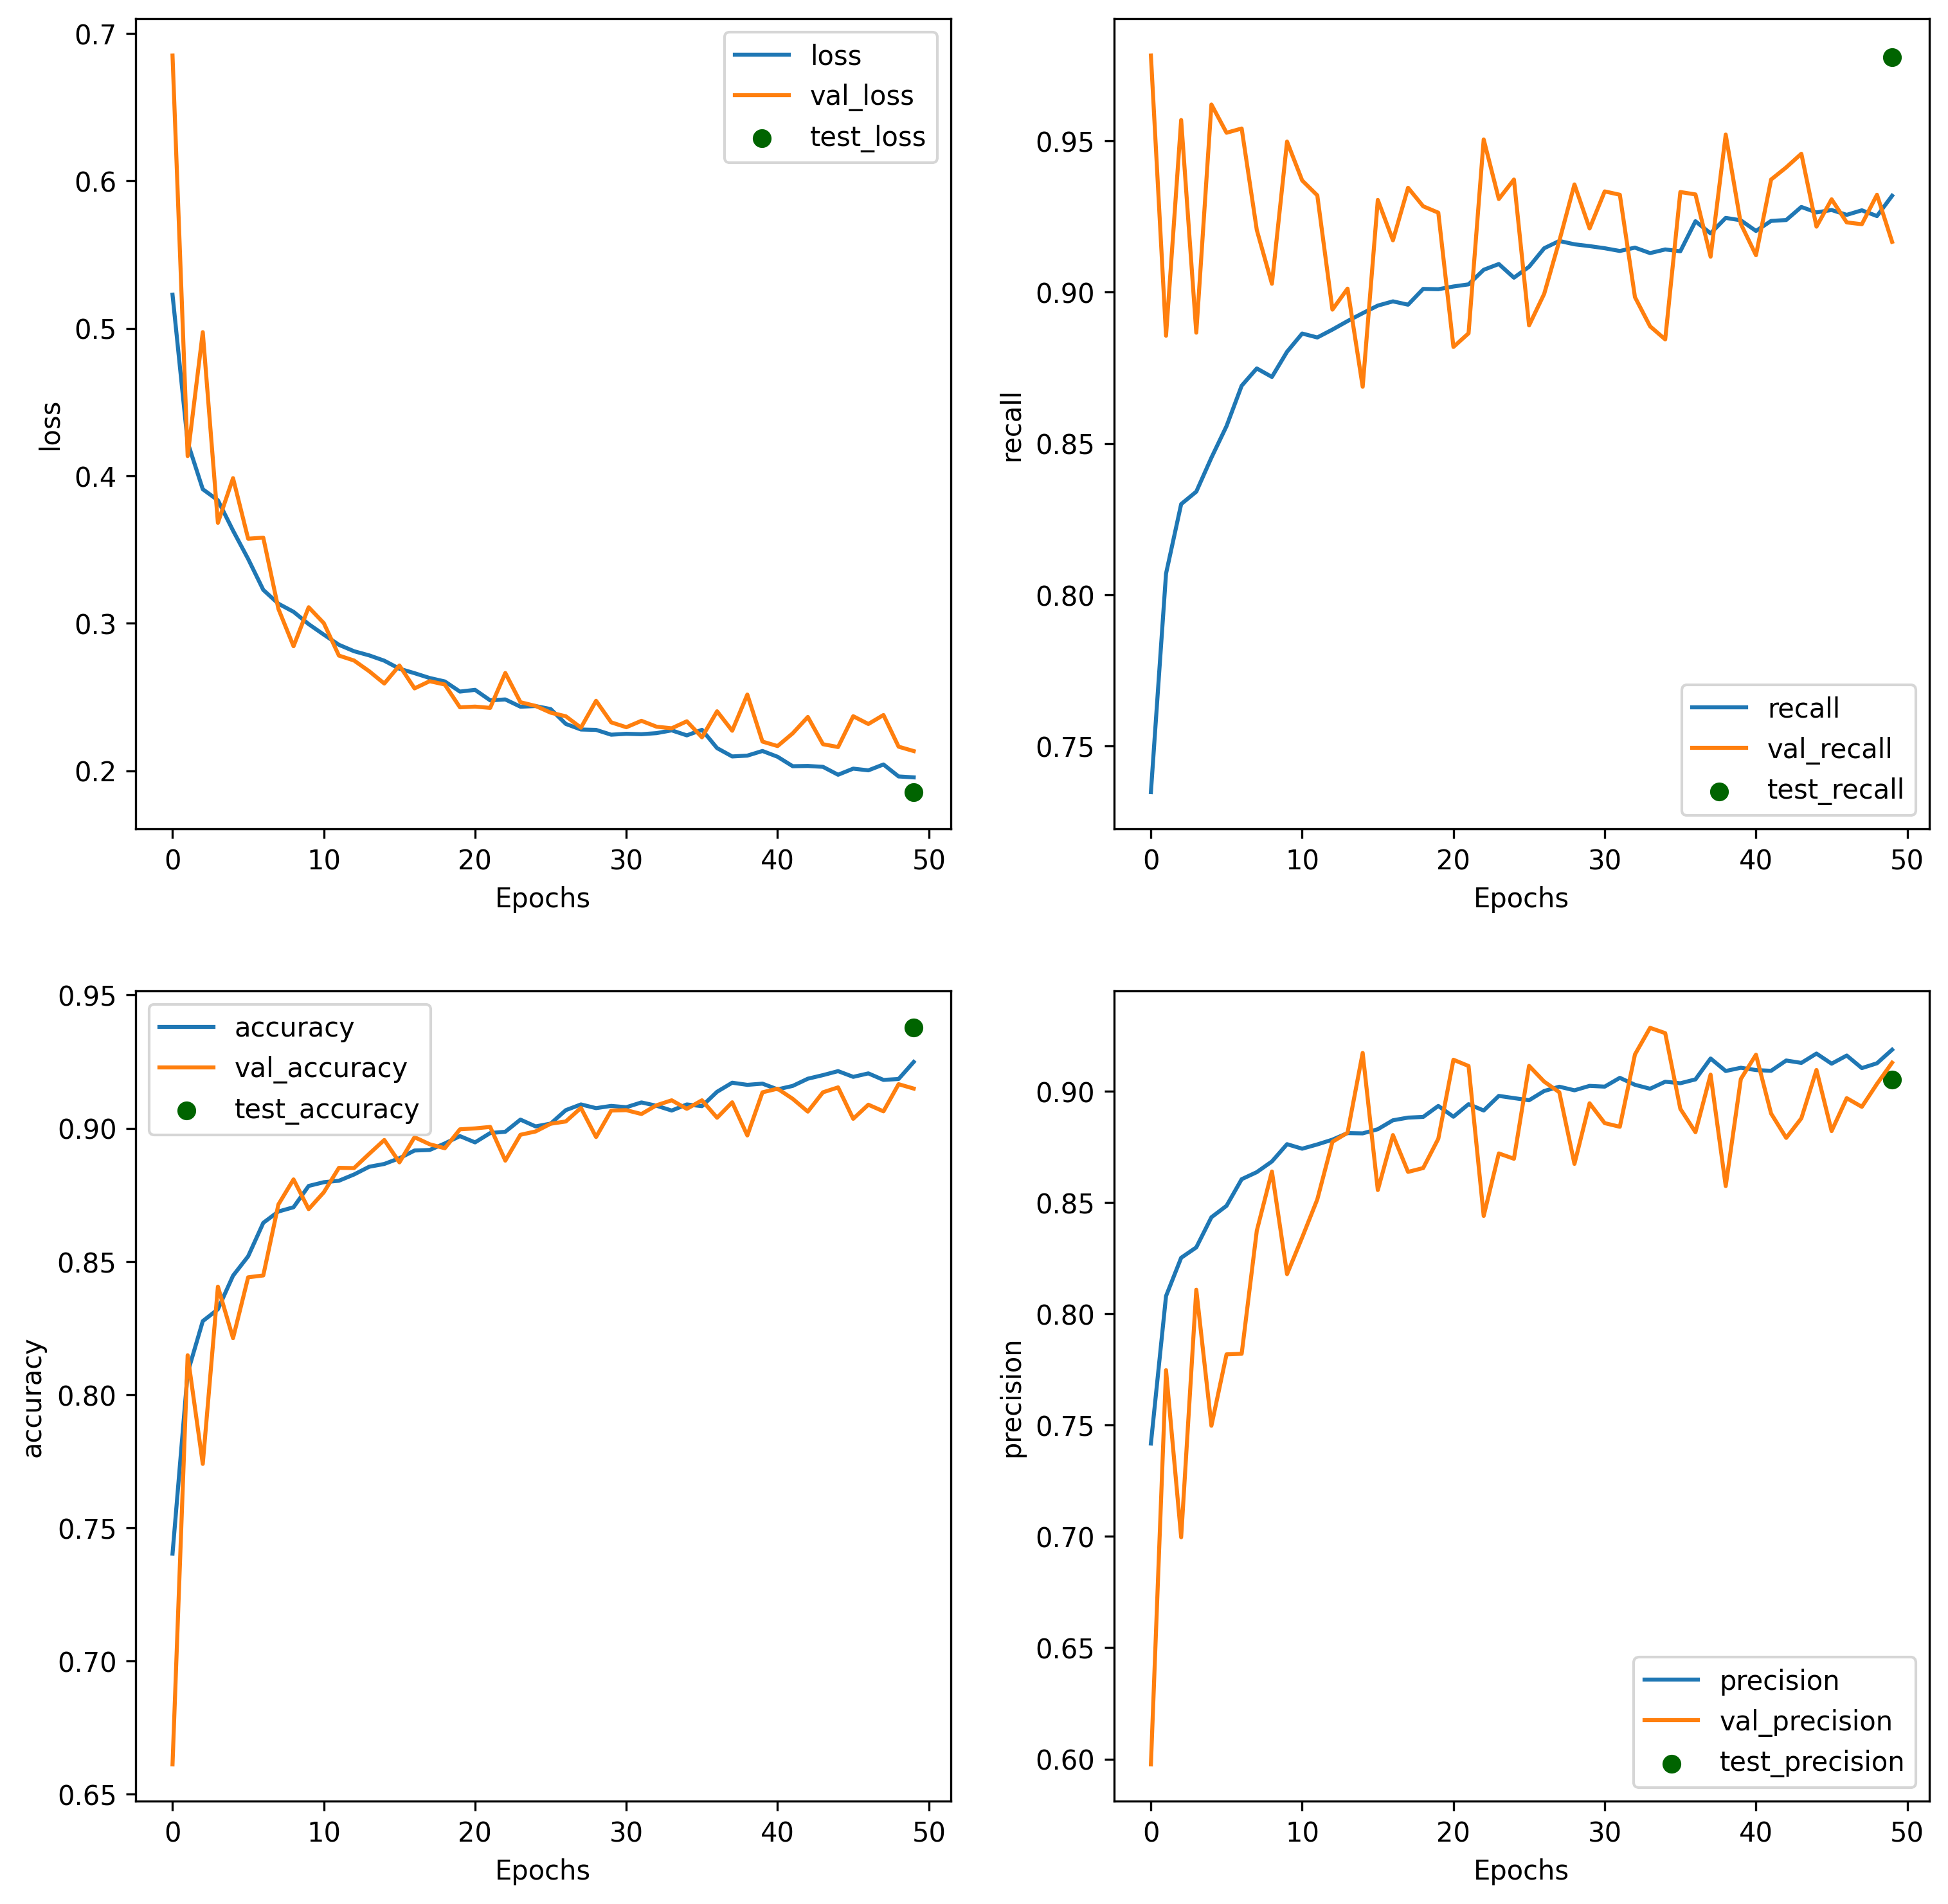

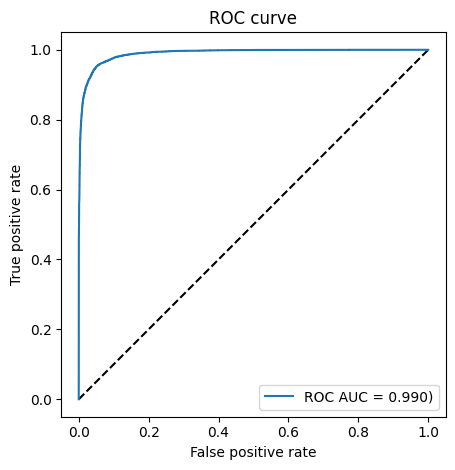

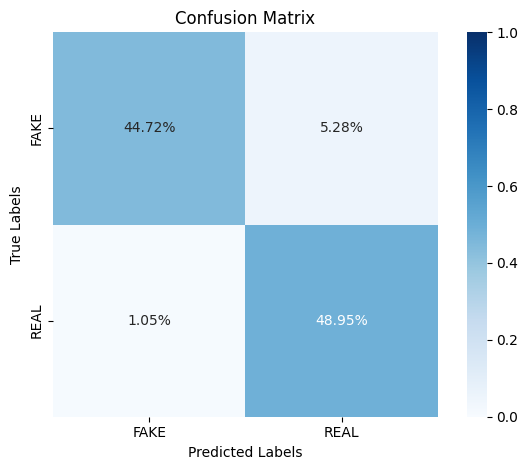

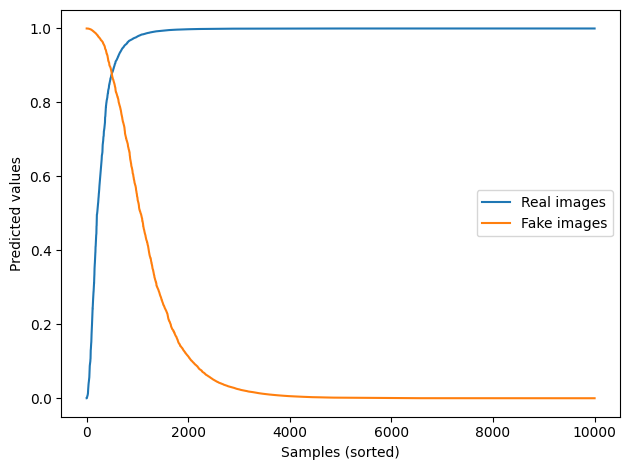

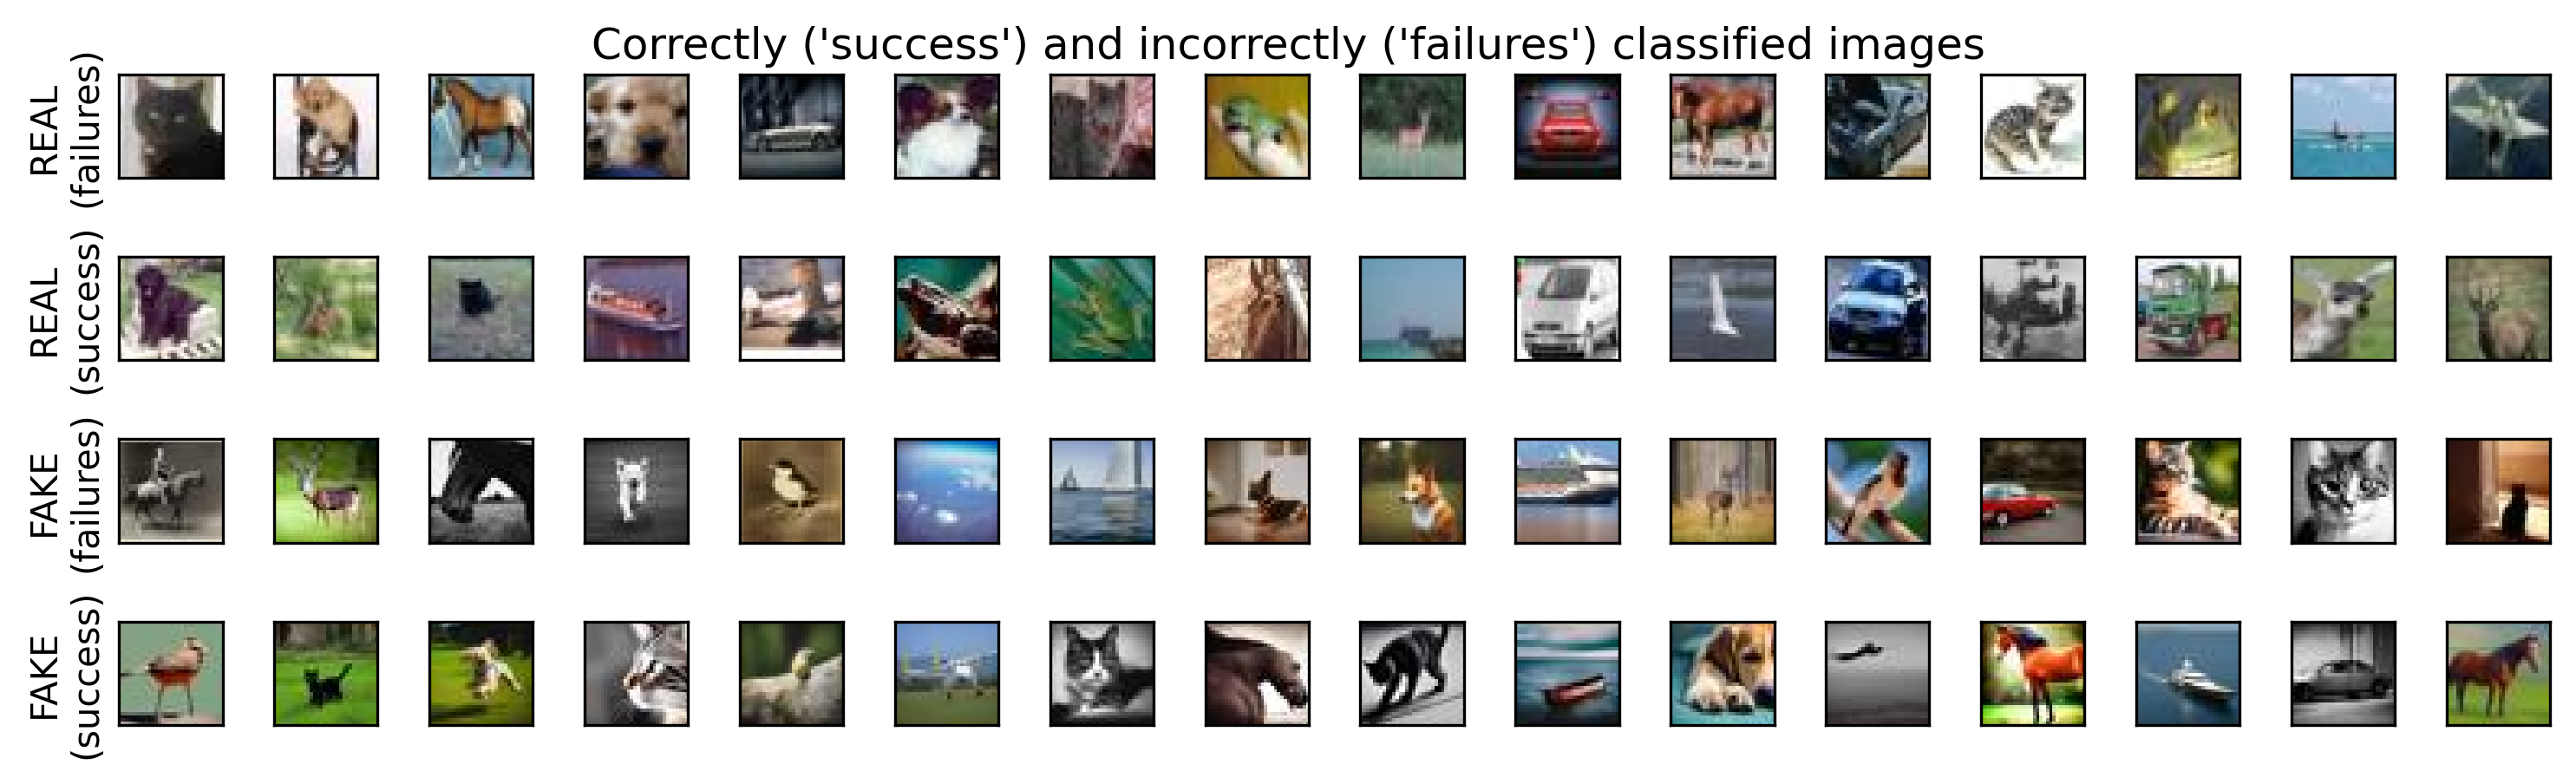

In [49]:
# Plot results
plot_metrics(history, test_loss, test_recall, test_accuracy, test_precision, number_of_epochs)
plot_roc_curve(labels, predicted_values)
plot_confusion_matrix(labels, predicted_classes, test_set_dataloader.class_names)
plot_predicted_values_per_class(predicted_values, labels)
plot_extreme_predictions(predicted_values, labels)

# Model 4 | U-Net Xception-style

In [53]:
"""
Credits: François Chollet
https://keras.io/examples/vision/oxford_pets_image_segmentation/
"""

def get_xception_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = tf.keras.layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = tf.keras.layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = tf.keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.UpSampling2D(2)(x)

        # Project residual
        residual = tf.keras.layers.UpSampling2D(2)(previous_block_activation)
        residual = tf.keras.layers.Conv2D(filters, 1, padding="same")(residual)
        x = tf.keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = tf.keras.layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model



In [55]:
# Build and compile the model, and show the summary
model = get_xception_model(img_size=(image_height, image_width), num_classes=2)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall')])
model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 16, 16,    │        896 │ input_layer_13[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        128 │ conv2d_63[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_30       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_31       │ (None, 16, 16,    │          0 │ activation_30[0]… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_12 │ (None, 16, 16,    │      2,400 │ activation_31[0]… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_32       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_13 │ (None, 16, 16,    │      4,736 │ activation_32[0]… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_30    │ (None, 8, 8, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 8, 8, 64)  │      2,112 │ activation_30[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 8, 8, 64)  │          0 │ max_pooling2d_30… │
│                     │                   │            │ conv2d_64[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_33       │ (None, 8, 8, 64)  │          0 │ add_14[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_14 │ (None, 8, 8, 128) │      8,896 │ activation_33[0]… │
│ (SeparableConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_34       │ (None, 8, 8, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                 

 Total params: 2,058,690 (7.85 MB)

 Trainable params: 2,054,914 (7.84 MB)

 Non-trainable params: 3,776 (14.75 KB)

In [56]:
# Train the model
number_of_epochs = 50
history = model.fit(
    train_set_dataloader, validation_data=validation_set_dataloader, epochs=number_of_epochs, verbose=2)

Epoch 1/50


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 32, 32, 2)

In [ ]:
# Infer the model
evaluate_model(model, validation_set_dataloader, 'Validation')
test_loss, test_accuracy, test_precision, test_recall = evaluate_model(model, test_set_dataloader, 'Test')
predicted_values, predicted_classes, labels = get_predictions_and_labels(test_set_dataloader, model)

In [ ]:
# Plot results
plot_metrics(history, test_loss, test_recall, test_accuracy, test_precision, number_of_epochs)
plot_roc_curve(labels, predicted_values)
plot_confusion_matrix(labels, predicted_classes, test_set_dataloader.class_names)
plot_predicted_values_per_class(predicted_values, labels)
plot_extreme_predictions(predicted_values, labels)

# Summary of key findings

# Potential flaws of the current analysis and possible future improvements